# Neural Network from Scratch in TensorFlow

# Task 1: Introduction and Importing Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nn_utils
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.1.0


# Task 2: Initializing Neural Network

In [3]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {} #weight
        self.b = {} #bias
        
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):

        for i in range(1, self.L):
            self.W[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], self.layers[i-1])))
            self.b[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], 1)))

# Task 3: Forward Pass

In [4]:
class NeuralNetwork(NeuralNetwork):
    #X is exmaples
    def forward_pass(self, X): # ex. X = 200 features, 50 examples, shape of X will be 50x200

        A = tf.convert_to_tensor(X, dtype = tf.float32)
        
        #for each layer, need to calculate output
        for i in range(1, self.L):
            
            #Z is linear output
            #linear sum is W multiplied by X plus b
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            
            if i != self.L-1: #if the layer is not the final layer
                A = tf.nn.relu(Z)
            else: #final layer
                A = Z
        return A #linear output

# Task 4: Computing Loss and Updating Parameters

In [5]:
#compute loss will be used to calculate backward propagation, will get gradients back and use 
#for parameters W and b to update their values

class NeuralNetwork(NeuralNetwork):

    def compute_loss(self, A, Y): #Y is the ground truth
        loss = tf.nn.softmax_cross_entropy_with_logits(Y, A) #loss on the batch
        return tf.reduce_mean(loss)
    
    def update_params(self, lr): #lr = learning rate
        for i in range(1, self.L): #need to update paramters for all layers except input
            #W is equal to W minus the content in brackets
            self.W[i].assign_sub(lr * self.dW[i]) #lr * self.dW[i] is all the gradients for the layer
            self.b[i].assign_sub(lr * self.db[i])

# Task 5: Predict and Info Functions

In [6]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):

        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis = 1) #looking for argmax for columns (axis=1)
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

# Task 6: Training on Batch

In [7]:
class NeuralNetwork(NeuralNetwork):
    #forward pass and compute loss and backward propagation for finding gradients 
    #and updating the gradients will happen in this function
    def train_on_batch(self, X, Y, lr): #X, Y are our batch
        
        #X, Y are numpy arrays, need to convert to tensors
        X = tf.convert_to_tensor(X, dtype = tf.float32)
        Y = tf.convert_to_tensor(Y, dtype = tf.float32)
        
        #in order to run backward propagation, we need to make sure we have a 
        #gradient tape and we compte loss within the gradient tape context
        
        with tf.GradientTape(persistent = True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        
        #calculating gradients for all layers
        for i in range(1, self.L):
            self.dW[i] = tape.gradient(loss, self.W[i]) 
            self.db[i] = tape.gradient(loss, self.b[i]) 
        
        del tape
        self.update_params(lr)
        
        #returning numeric value of loss after this training
        return loss.numpy()    
        

# Task 7: Training on Complete Set

In [18]:
class NeuralNetwork(NeuralNetwork):
    #gets entire training set and test set, and will use train_batch
    #keeps track of training loss, validation loss, training accuracy, to help determine
    #if training worked well
    
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):

        history = {
            'val_loss': [], 
            'train_loss': [],
            'val_acc': []
        }
        
        #instead of running all iterations for all examples, we are breaking it down 
        #into mini batches (mini batches gradient desent)
        
        #ex. batch_size = 100, 1000 examples, 10 steps per epoch, that will be 10 batches within one epoch
        for e in range(0, epochs):
            epoch_train_loss = 0
            print('Epoch {}'.format(e), end = '.')
            
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size] #has examples only corresponding to the batch size
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                
                #does back prop, updates params and returns a numeric value for the loss
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                
                epoch_train_loss += batch_loss
                
                #prints a dot for every 1/10th of progress
                if i%int(steps_per_epoch/10) == 0:
                    print(end = '.')
                
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'].append(val_loss)
            val_preds = self.predict(x_test)
            val_acc = np.mean(np.argmax(y_test, axis = 1) == val_preds.numpy())
            history['val_acc'].append(val_acc)
            
            print('Val acc: ', val_acc)
        return history

# Task 8: Application

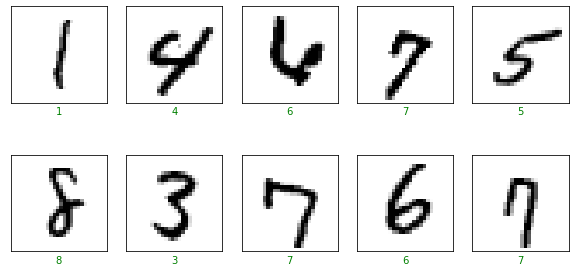

In [19]:
(x_train, y_train), (x_test, y_test) = nn_utils.load_data()

nn_utils.plot_random_examples(x_train, y_train).show()

In [20]:
net = NeuralNetwork([784, 128, 128, 10]) #hidden layers 128,128, 10 classes (0-9)
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [21]:
batch_size = 120
epochs = 5 #we have 60000 examples
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3 #can change, most common lr will work
print('Steps per epoch', steps_per_epoch)

Steps per epoch 500


In [22]:
history = net.train(
    x_train, y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 0...........Val acc:  0.8093
Epoch 1...........Val acc:  0.8403
Epoch 2...........Val acc:  0.8512
Epoch 3...........Val acc:  0.8576
Epoch 4...........Val acc:  0.8629


# Task 9: Results

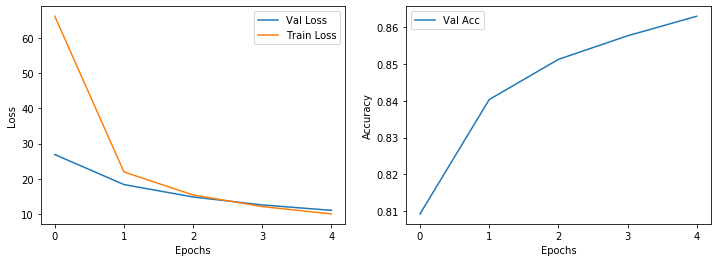

In [23]:
nn_utils.plot_results(history).show()

In [24]:
preds = net.predict(x_test)

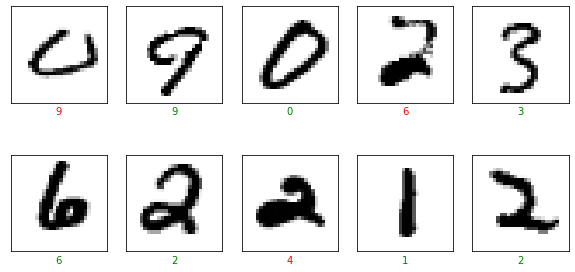

In [27]:
nn_utils.plot_random_examples(x_test, y_test, preds.numpy()).show()